<a href="https://colab.research.google.com/github/AlirezaAbedinii/ImageCaptioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import zipfile
from tensorflow.keras.applications.resnet50 import ResNet50
import re
import tqdm
import pickle


In [2]:
from collections import defaultdict
import json
import time
import itertools
import os, os.path

In [3]:
%matplotlib inline 
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab
import random
from shutil import copyfile
import cv2
import time
from PIL import Image

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

# Globals

## Variables

In [5]:
dataDir='/content/drive/MyDrive/Dataset/annotations_trainval2017.zip (Unzipped Files)'
dataType='val2017'
pictures_dir_path = "/content/drive/MyDrive/Dataset/val2017.zip (Unzipped Files)/val2017"
train_dir_path = "/content/drive/MyDrive/Dataset/Train"
test_dir_path = "/content/drive/MyDrive/Dataset/Test"
global_images_ids = []
global_data = []
global_test_data = []
global_train_data = []
train_pics = []
test_pics = []
dataset = pd.DataFrame(columns = ['id', 'is_training' 'r', 'g', 'b',
                                  'captions', 'url'])
train_df_path = '/content/drive/MyDrive/Dataset/train_data.csv'
test_df_path = '/content/drive/MyDrive/Dataset/test_data.csv'

embedding_dim = 2048
max_length = 10
num_words = 4000
train_caps = {}

In [6]:
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=2.89s)
creating index...
index created!


## Classes

In [7]:
class Data:
  def __init__(self, id, captions):
    self.id = id
    self.captions = captions
    self.image = img_id_to_data(self.id)
  
  def show_info(self):
    show_img_by_file(pictures_dir_path + "/" + img_id_to_url(self.id))
    print(self.captions)
    

## Methods

In [8]:
def show_img_by_file(file_address):
  plt.imshow(mpimg.imread(file_address))
  plt.axis('off')
  plt.show()

def img_id_to_url(img_id, img_type='jpg'):
  str_id = str(img_id)

  return str_id.zfill(12) + '.' + img_type

def img_id_to_data(img_id, img_height=224, img_width=224):
  url = img_id_to_url(img_id)
  img_path = pictures_dir_path+'/'+url
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
  # img = mpimg.imread(pictures_dir_path+'/'+url)
  # img = Image.open(img_path).convert('RGB')

  input_arr = tf.keras.preprocessing.image.img_to_array(img)
  
  # img /= 255.
  input_arr /= 255.
  
  return input_arr

def show_image_by_data(img):
  plt.imshow(img)
  plt.show()


# Dataset

## Train/Test Split

In [9]:
def split_data(source_dir, train_dir, test_dir, split_size):
  items = os.listdir(source_dir)
  items = random.sample(items, len(items))

  for i in range(len(items)):
    if i < split_size * len(items):
      copyfile(os.path.join(source_dir, items[i]), os.path.join(train_dir, items[i]))
    else:
      copyfile(os.path.join(source_dir, items[i]), os.path.join(test_dir, items[i]))

In [10]:
# Run the line below just for the first time
# split_data(pictures_dir_path, train_dir_path, test_dir_path, 0.8)
print(len(os.listdir(train_dir_path)), len(os.listdir(test_dir_path)))

4000 1000


## Load Images and Captions



In [11]:
def img_url_to_id(img_url, img_type='jpg'):
  return int(img_url[:-len(img_type)-1])

def load_img_captions(img_id):
  captions = []
  annIds = coco_caps.getAnnIds(imgIds=img_id);
  anns = coco_caps.loadAnns(annIds)
  for ann in anns:
    captions.append(ann['caption'])
  return captions

def load_imgs_and_caps(source_dir, is_training):
  global global_data, global_train_data, get_test_data
  images = os.listdir(source_dir)
  counter = 0
  # new
  total_ids = []
  total_is_trainings = []
  total_rs = []
  total_gs = []
  total_bs = []
  total_caps = []
  total_urls = []
  # new
  for img_url in images:
    # t1 = time.time()
    img_id = img_url_to_id(img_url)
    captions = load_img_captions(img_id)
    # data = Data(id = img_id, captions = captions)
    # new
    total_ids.append(img_id)
    total_is_trainings.append(is_training)

    t1 = time.time()
    img_data = img_id_to_data(img_id)

    # t2 = time.time()
    # print(f'1: {t2-t1}')

    total_rs.append(img_data) ###
    total_gs.append(img_data[1])
    total_bs.append(img_data[2])
    total_caps.append(captions)
    total_urls.append(img_url)
    
    t3 = time.time()
    # print(f'2: {t3-t2}')
    # new


    # global_data.append(data)
    if counter % 200 == 0: 
      print(f'{counter} images loaded')
    counter += 1
    # if is_training:
    #   global_train_data.append(data)
    #   train_pics.append(data.image)
    #   # train_pics.append(data)
    # else:
    #   global_test_data.append(data)
    #   test_pics.append(data.image)
    #   # test_pics.append(data)
    t3 = time.time()
    # print(f'2: {t3-t2}')
  return pd.DataFrame({
        "id": total_ids,
        "is_training": total_is_trainings,
        'r': total_rs,
        'g': total_gs,
        'b': total_bs,
        'captions': total_caps,
        'url': total_urls
    })

## Load and Save images to dataframes

In [12]:
"""
The code below load all images from the directories and save the required data
to dataframes (train, test), and then save it for the further usage.
"""
# train_df = load_imgs_and_caps(train_dir_path, True)
# print(len(global_train_data), len(global_test_data), len(global_data))
# test_df = load_imgs_and_caps(test_dir_path, False)
# print(len(global_train_data), len(global_test_data), len(global_data))
# train_df.to_csv("/content/drive/MyDrive/Dataset/train_data.csv", sep=',')
# test_df.to_csv('/content/drive/MyDrive/Dataset/test_data.csv', sep=',')

'\nThe code below load all images from the directories and save the required data\nto dataframes (train, test), and then save it for the further usage.\n'

## Read data from dataframes

In [13]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

### Delete extra rows

In [14]:
train_df = train_df.drop(columns=['Unnamed: 0'])
test_df = test_df.drop(columns=['Unnamed: 0'])


### Get Image data

In [15]:
def string_to_array(raw_str, shape = [224,224]):

  edited = raw_str.replace('[', '')
  edited = edited.replace('\n','')
  edited = edited.replace(']', '')
  edited = re.sub(' +', ' ', edited)
  edited = np.fromstring(edited, dtype=float, sep=' ')
  return edited.reshape(shape)
  # print(edited)

In [16]:
# string_to_array(train_df['r'][0])
def all_data(ids):
  data = []
  counter = 0
  for id in ids:
    data.append(img_id_to_data(id))
    if counter % 200 == 0: 
      print(f'{counter} images loaded')
    counter += 1
  return data

## New way

In [17]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = tf.keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x

In [18]:
# Load the inception v3 model
input1 = tf.keras.applications.InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
pt_model = tf.keras.models.Model(input1.input, input1.layers[-2].output)

96124928/96112376 [==============================] - 3s 0us/step


In [19]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = pt_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [20]:
"""
Run the code below for the first run
"""
# encoding = {}
# pre_path = '/content/drive/MyDrive/Dataset/Train/'
# for url in tqdm.tqdm(train_df['url']):
#     encoding[url] = encode(pre_path+url)

'\nRun the code below for the first run\n'

In [21]:
"""
Run the code below for the first run
"""
# Save the features in the images1 pickle file
# with open("/content/drive/MyDrive/train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding, encoded_pickle)

'\nRun the code below for the first run\n'

In [22]:
# print(encoding['000000000139.jpg'])

### load features

In [23]:
features = pickle.load(open("/content/drive/MyDrive/images1.pkl", "rb"))

In [24]:
# testing
print(features['000000308587.jpg'])

[0.6432799  0.0756029  0.82783073 ... 0.64724636 0.11487135 0.03778623]


# Captions Processing

## Build Vocabularies

### Load captions (endseq)

In [25]:
def add_endseq(input_str):
  return input_str + ' ' + 'endseq'

#Load caption and add endseq at the end of them
def create_captions_dic(inp_coco_caps):
  captions_dic = {}
  images = os.listdir(train_dir_path)
  for img_url in images:
    img_id = img_url_to_id(img_url)
    annIds2 = inp_coco_caps.getAnnIds(imgIds=img_id)
    anns2 = inp_coco_caps.loadAnns(annIds2)
    counter = 0
    for ann in anns2:
      counter += 1
      # there are 13 images with 6 captions, not 5
      # if counter > 5:
      #   print (img_id)
      edited_caption = add_endseq(ann['caption'])
      if ann['image_id'] not in captions_dic:
        captions_dic[ann['image_id']] = [edited_caption]
      else:
        captions_dic[ann['image_id']].append(edited_caption)

  return captions_dic


In [26]:
train_caps = create_captions_dic(coco_caps)

#Test
print(train_caps[289516])

['A clock sits above green bushes under a blue sky. endseq', 'A clock on a stand displays the time in a garden. endseq', 'A clock that is surrounded by tall grass in a park. endseq', 'An old time looking clock surrounded by greenery.  endseq', 'An old standing clock surrounded by tall grass. endseq', 'A clock set to twenty after three in a field endseq']


### Tokenization

#### Making a list of all captions

In [27]:
len(train_caps.values())
flat_train_caps = [cap for sublist in train_caps.values() for cap in sublist]

In [28]:
print(len(flat_train_caps))
print(len(train_caps.values()))

20013
4000


#### Tokenizing captions

In [29]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(oov_token='OOV', 
                      filters= "!'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n",
                      num_words=num_words)

# Generate the word index dictionary
tokenizer.fit_on_texts(flat_train_caps)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'OOV': 1, 'a': 2, 'endseq': 3, 'on': 4, 'of': 5, 'the': 6, 'in': 7, 'with': 8, 'and': 9, 'is': 10, 'to': 11, 'man': 12, 'sitting': 13, 'two': 14, 'an': 15, 'standing': 16, 'at': 17, 'people': 18, 'next': 19, 'are': 20, 'white': 21, 'woman': 22, 'street': 23, 'table': 24, 'that': 25, 'it': 26, 'holding': 27, 'large': 28, 'person': 29, 'some': 30, 'tennis': 31, 'top': 32, 'group': 33, 'field': 34, 'train': 35, 'up': 36, 'down': 37, 'near': 38, 'black': 39, 'front': 40, 'plate': 41, 'cat': 42, 'small': 43, 'dog': 44, 'riding': 45, 'room': 46, 'playing': 47, 'young': 48, 'his': 49, 'red': 50, 'baseball': 51, 'by': 52, 'has': 53, 'water': 54, 'building': 55, 'walking': 56, 'sign': 57, 'bathroom': 58, 'side': 59, 'food': 60, 'while': 61, 'green': 62, 'pizza': 63, 'bus': 64, 'grass': 65, 'blue': 66, 'looking': 67, 'other': 68, 'there': 69, 'clock': 70, 'ball': 71, 'parked': 72, 'kitchen': 73, 'for': 74, 'game': 75, 'three': 76, 'city': 77, 'toilet': 78, 'men': 79, 'roa

In [55]:
# Testing the tokenizer
tseq = tokenizer.texts_to_sequences(['Let us play some ball', 'asdlk ha sdjh askdjhasd hkajsd'])
print(tseq[0][:2], tseq[][2:])

[2309, 1717] [406, 30, 71]


In [31]:
cap_lengths = [len(item.split(' ')) for item in flat_train_caps]
result = np.where(cap_lengths == np.amax(cap_lengths))
cap_lengths.sort(reverse = True)
len(cap_lengths)

20013

### Download Glove pretrained embedding

In [ ]:
"""
only first time
"""
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-09-23 08:21:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-23 08:21:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-23 08:21:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
"""
Only the first time
"""
# !unzip /content/glove.6B.zip -d /content/drive/MyDrive/Dataset/Glove/

Archive:  /content/glove.6B.zip
  inflating: /content/drive/MyDrive/Dataset/Glove/glove.6B.50d.txt  
  inflating: /content/drive/MyDrive/Dataset/Glove/glove.6B.100d.txt  
  inflating: /content/drive/MyDrive/Dataset/Glove/glove.6B.200d.txt  
  inflating: /content/drive/MyDrive/Dataset/Glove/glove.6B.300d.txt  


In [85]:
tword, *tvector = 'Hey man SUP? wyd'.split()
print(tword,tvector)

Hey ['man', 'SUP?', 'wyd']


In [98]:
def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
  # num _words instead of word index length
  vocab_size = num_words + 1
    
  # Adding again 1 because of reserved 0 index
  embedding_matrix_vocab = np.zeros((vocab_size,
                                      embedding_dim))

  with open(filepath, encoding="utf8") as f:
    for line in f:
      word, *vector = line.split()
      # adding index if
      if word in word_index and word_index[word] < num_words:
        idx = word_index[word]
        embedding_matrix_vocab[idx] = np.array(
            vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix_vocab
  

In [99]:
embedding_matrix = embedding_for_vocab('/content/drive/MyDrive/Dataset/Glove/glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

In [101]:
print(len(embedding_matrix))

4001


# Decoder

In [32]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    
    ### START CODE HERE
    for line in corpus:
      current_sequence = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(current_sequence)):
        input_sequences.append(current_sequence[0: i+1])
    ### END CODE HERE
    
    return input_sequences

In [73]:
def train_generator(tokenizer, captions, photos, batch_size):
  image_inp, sequence_inp, out_word = list(), list(), list()
  n=0
  # loop for ever over images
  while True:
      for img_id, caps_list in train_caps.items():
          n+=1
          # retrieve the photo feature
          photo = photos[img_id_to_url(img_id)]
          for cap in caps_list:
              # encode the sequence
              seq = tokenizer.texts_to_sequences([cap])[0]
              # print(seq)
              # return
              # seq = [tokenizer.word_index[word] for word in cap.split(' ') if word in tokenizer.word_index]
              
              # split one sequence into multiple X, y pairs
              for i in range(1, min(max_length+1, len(seq))):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                  # encode output sequence
                  out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=num_words)[0]
                  # store
                  image_inp.append(photo)
                  sequence_inp.append(in_seq)
                  out_word.append(out_seq)
          # yield the batch data
          if n==batch_size:
              yield ([np.array(image_inp), np.array(sequence_inp)], np.array(out_word))
              image_inp, sequence_inp, out_word = list(), list(), list()
              n=0

In [63]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(num_words, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)

decoder1 = add([fe2, se3])
# decoder1 = add([inputs1, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(num_words, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 10, 2048)     8192000     ['input_19[0][0]']               
                                                                                                  
 dropout_15 (Dropout)           (None, 2048)         0           ['input_18[0][0]']               
                                                                                            

In [74]:

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 10
batch_size = 16
steps = len(train_caps)//batch_size

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = train_generator(tokenizer, train_caps, features, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


250/250 [==============================] - 43s 173ms/step - loss: 1.9094


# Caption Generation

# CNN

## Preprocess

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

## Model

In [ ]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  for layer in feature_extractor.layers:
    layer.trainable = False
  return feature_extractor



'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.Resizing(224, 224)(inputs)

    resnet_feature_extractor = feature_extractor(resize)

    return resnet_feature_extractor

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  # inputs = train_pics
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  # model.compile(optimizer='SGD', 
                # loss='sparse_categorical_crossentropy',
                # metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

AttributeError: ignored

# Test

## Captions

In [ ]:
dataDir='/content/drive/MyDrive/Dataset/annotations_trainval2017.zip (Unzipped Files)'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [ ]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


## Show test

In [ ]:
DIR = '/content/drive/MyDrive/Dataset/val2017.zip (Unzipped Files)/val2017'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

5000


{'license': 2, 'file_name': '000000000139.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000000139.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-21 01:34:01', 'flickr_url': 'http://farm9.staticflickr.com/8035/8024364858_9c41dc1666_z.jpg', 'id': 139}
A woman stands in the dining area at the table. {'image_id': 139, 'id': 376968, 'caption': 'A room with chairs, a table, and a woman in it.'}
A woman stands in the dining area at the table.
A room with chairs, a table, and a woman in it.
A woman standing in a kitchen by a window
A person standing at a table in a room.
A living area with a television and a table


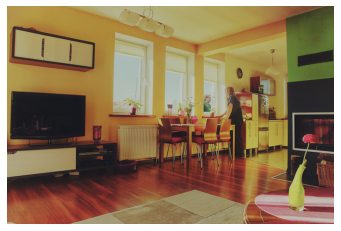

In [ ]:
img = coco_caps.loadImgs(ids = [139])[0]

print(img)

annIds = coco_caps.getAnnIds(imgIds=139);
anns = coco_caps.loadAnns(annIds)
print(anns[0]['caption'], anns[1])
coco_caps.showAnns(anns)
plt.imshow(mpimg.imread("/content/drive/MyDrive/Dataset/val2017.zip (Unzipped Files)/val2017/000000000139.jpg"))
# plt.imshow(io.imread(img['coco_url']))
plt.axis('off')
plt.show()

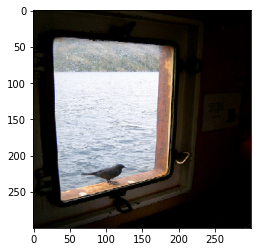

In [ ]:
# processed_train_data = preprocess_image_input(np.array(train_pics))
# processed_train_data[0]
plt.imshow(test_pics[200])
plt.show()